
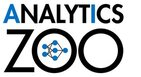
---

##### Copyright 2018 Analytics Zoo Authors.

In [31]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

## **Environment Preparation**

**Install Java 8**

Run the cell on the **Google Colab** to install jdk 1.8.

**Note:** if you run this notebook on your computer, root permission is required when running the cell to install Java 8. (You may ignore this cell if Java 8 has already been set up in your computer).


In [32]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
# Set environment variable JAVA_HOME.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

openjdk version "1.8.0_292"
OpenJDK Runtime Environment (build 1.8.0_292-8u292-b10-0ubuntu1~18.04-b10)
OpenJDK 64-Bit Server VM (build 25.292-b10, mixed mode)


**Install Analytics Zoo**

You can install the latest pre-release version using `pip install --pre --upgrade analytics-zoo`. 

In [33]:
# Install latest pre-release version of Analytics Zoo 
# Installing Analytics Zoo from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install --pre --upgrade analytics-zoo

Requirement already up-to-date: analytics-zoo in /usr/local/lib/python3.7/dist-packages (0.11.0b20210512)


In [34]:
# Install required dependencies
!pip install ray[tune]==1.2.0
!pip install xgboost==1.3.3

## **This document explains how to use auto xgboost for regression**

First of all, here you can use the data set we have prepared, just download it.

## **Step 0: Prepare dataset**

In [35]:
if not os.path.exists('incd.csv'):
  !wget https://raw.githubusercontent.com/intel-analytics/analytics-zoo/master/pyzoo/zoo/examples/orca/automl/autoxgboost/incd.csv
  print('download completed.')
else:
  print('incd exists.')

incd exists.


In [36]:
import pandas as pd
df = pd.read_csv('./incd.csv', encoding='latin-1')
# specify the column of the classification
feature_cols = ["FIPS", "Lower 95% Confidence Interval", "Upper 95% Confidence Interval",
                "Average Annual Count", "Recent 5-Year Trend"]
target_col = "Age-Adjusted Incidence Rate"
X = df[feature_cols]
y = df[[target_col]]

In [37]:
df.head()

,County,FIPS,Age-Adjusted Incidence Rate,Lower 95% Confidence Interval,Upper 95% Confidence Interval,Average Annual Count,Recent Trend,Recent 5-Year Trend,Lower 95% Confidence Interval.1,Upper 95% Confidence Interval.1
0,"US (SEER+NPCR)(1,10)",0,62.4,62.3,62.6,214614,falling,-2.5,-3.0,-2.0
1,"Autauga County, Alabama(6,10)",1001,74.9,65.1,85.7,43,stable,0.5,-14.9,18.6
2,"Baldwin County, Alabama(6,10)",1003,66.9,62.4,71.7,170,stable,3.0,-10.2,18.3
3,"Barbour County, Alabama(6,10)",1005,74.6,61.8,89.4,25,stable,-6.4,-18.3,7.3
4,"Bibb County, Alabama(6,10)",1007,86.4,71.0,104.2,23,stable,-4.5,-31.4,32.9


In [38]:
# split train_set and test_set.
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

### **Step 1: Init Orca Context** 

In [39]:
from zoo import init_spark_on_local,init_spark_on_yarn
from zoo.ray import RayContext
from zoo.orca import OrcaContext

This is the only place where you need to specify local or distributed mode. View [Orca Context](https://analytics-zoo.readthedocs.io/en/latest/doc/Orca/Overview/orca-context.html) for more details.

**Note**: You should export HADOOP_CONF_DIR=/path/to/hadoop/conf/dir when you run on Hadoop YARN cluster.

In [40]:
# recommended to set it to True when running Analytics Zoo in Jupyter notebook 
OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

hadoop_conf = "local"

if hadoop_conf == 'yarn': # run on yarn clusters
    sc = init_spark_on_yarn(
        hadoop_conf=hadoop_conf,
        conda_name=conda_name, # "conda_name must be specified for yarn mode"
        num_executors=num_workers,
        executor_cores=executor_cores)
else: # run in local model
    sc = init_spark_on_local(cores="*")
ray_ctx = RayContext(sc=sc)
ray_ctx.init()

Current pyspark location is : /usr/local/lib/python3.7/dist-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.7/dist-packages/zoo/share/lib/analytics-zoo-bigdl_0.12.2-spark_2.4.3-0.11.0-SNAPSHOT-jar-with-dependencies.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/lib/bigdl-0.12.2-jar-with-dependencies.jar --driver-class-path /usr/local/lib/python3.7/dist-packages/zoo/share/lib/analytics-zoo-bigdl_0.12.2-spark_2.4.3-0.11.0-SNAPSHOT-jar-with-dependencies.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/lib/bigdl-0.12.2-jar-with-dependencies.jar pyspark-shell 
Successfully got a SparkContext


2021-05-14 08:25:42,019	INFO services.py:1174 -- View the Ray dashboard at http://172.28.0.2:8265


{'node_ip_address': '172.28.0.2', 'raylet_ip_address': '172.28.0.2', 'redis_address': '172.28.0.2:6379', 'object_store_address': '/tmp/ray/session_2021-05-14_08-25-41_499282_58/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2021-05-14_08-25-41_499282_58/sockets/raylet', 'webui_url': '172.28.0.2:8265', 'session_dir': '/tmp/ray/session_2021-05-14_08-25-41_499282_58', 'metrics_export_port': 56703, 'node_id': 'dfd6191c2303cdd278baac6f0ef433bccc59371ce399744d4b27679a'}


{'metrics_export_port': 56703,
 'node_id': 'dfd6191c2303cdd278baac6f0ef433bccc59371ce399744d4b27679a',
 'node_ip_address': '172.28.0.2',
 'object_store_address': '/tmp/ray/session_2021-05-14_08-25-41_499282_58/sockets/plasma_store',
 'raylet_ip_address': '172.28.0.2',
 'raylet_socket_name': '/tmp/ray/session_2021-05-14_08-25-41_499282_58/sockets/raylet',
 'redis_address': '172.28.0.2:6379',
 'session_dir': '/tmp/ray/session_2021-05-14_08-25-41_499282_58',
 'webui_url': '172.28.0.2:8265'}

### **Step 2: Create a XgbRegressorGridRandomRecipe**

*    More details about XgbRegressGridRandomRecipe, please refer to [here](https://analytics-zoo.github.io/master/#APIGuide/AutoML/recipe/#recipe).
*   In addition, we also have "sigopt" and "skopt". the default gridrandom is used here.


In [41]:
from zoo.zouwu.config.recipe import XgbRegressorGridRandomRecipe

# specify gridrandom search parameters
num_rand_samples = 10
n_estimators_range = (800, 1000)
max_depth_range = (10, 15)
lr = (1e-4, 1e-1)
min_child_weight = [1, 2, 3]

recipe = XgbRegressorGridRandomRecipe(num_rand_samples=num_rand_samples,
                                      n_estimators=list(n_estimators_range),
                                      max_depth=list(max_depth_range),
                                      lr=lr,
                                      min_child_weight=min_child_weight
                                      )

search_alg = None
search_alg_params = None
scheduler = None
scheduler_params = None

### **Setp 3: Create an AutoXGBRegressor**

*   AutoXGBRegressor is automated xgboost regressor.
  * logs_dir: Local directory to save logs and results.
  * n_jobs: Number of cpus for each trial. 
  * name: Name of the auto xgboost classifier.
  * xgb_configs: Note that we will directly use cpus_per_trial value for n_jobs in xgboost and you shouldn't specify n_jobs again.

In [42]:
from zoo.orca.automl.xgboost import AutoXGBRegressor

config = {'random_state': 2,
          'min_child_weight': 3}

# init an autoxgbregressor
auto_xgb_reg = AutoXGBRegressor(cpus_per_trial=2, name="auto_xgb_regressor", **config)

### **Step 4: Fit with AutoXGBRegressor**

In [43]:
data = {'x': X_train, 'y': y_train, 'val_x': X_val, 'val_y': y_val}
auto_xgb_reg.fit(data,
                # = (X_train, y_train),
                # validation_data=(X_val, y_val),
                recipe=recipe,
                metric="rmse",
                search_alg=search_alg,
                search_alg_params=None,
                # n_sampling=recipe.num_samples(),
                # search_space=recipe.search_space(),
                scheduler=scheduler,
                scheduler_params=scheduler_params)
print("Training completed.")

2021-05-14 08:29:31,005	INFO tune.py:450 -- Total run time: 201.44 seconds (201.40 seconds for the tuning loop).


Training completed.


### **Step 5: evaluate model resultst**

In [44]:
# get_best_model will return the best performing model
best_model = auto_xgb_reg.get_best_model()
# predict with the best trial
y_hat = best_model.predict(X_val)

In [45]:
# evaluate the resultst
rmse = best_model.evaluate(X_val, y_val, metrics=["rmse"])
# rmse is a list nested array type
print(f"Evaluate: the square root of mean square error is {rmse[0][0]:.2f}")

Evaluate: the square root of mean square error is 1.05


In [46]:
# stop sc and ray_ctx when your program finishes
ray_ctx.stop()
sc.stop()